In [ ]:
# Using:
# - Python 3.8.8
# - PyTorch 1.8.1

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, TensorDataset

# Generative model

### Data import

In [2]:
def get_dataset():
    with open("data_corridor_two_13000.json", "r") as read_file:
        data = json.load(read_file)
        
        pos = np.array(list(map(lambda x: [
            x['position']['x'],
            x['position']['y']
        ], data)))
        
                
        ranges = np.array(list(map(lambda x: x['laser_ranges'], data)))        
        ranges[ranges == np.inf] = 15  # replaces infinity values with 20
        
        # Ranges in all samples are prefixed and sufixed with 22 constant values (close to 0)
        trim_size = 22
        for i in range(0, trim_size):
            ranges = np.delete(ranges, 0, axis=1)
        for i in range(0, trim_size):
            ranges = np.delete(ranges, len(ranges[0]) - 1, axis=1)
        
    return pos, ranges

In [3]:
pos, ranges = get_dataset()

### Data visualization

In [4]:
ranges_len = len(ranges[0])
def range_angle(idx):
    return -10 + (idx * 200 / ranges_len)

def prettify_ranges(ranges):
    ranges_plot = []
    for i, val in enumerate(ranges):
        x, y = (0, 0)

        # find the end point    
        endy = y + val * math.sin(math.radians(range_angle(i)))
        endx = val * math.cos(math.radians(range_angle(i)))

        ranges_plot.append([endx, endy])
    
    return np.array(ranges_plot)

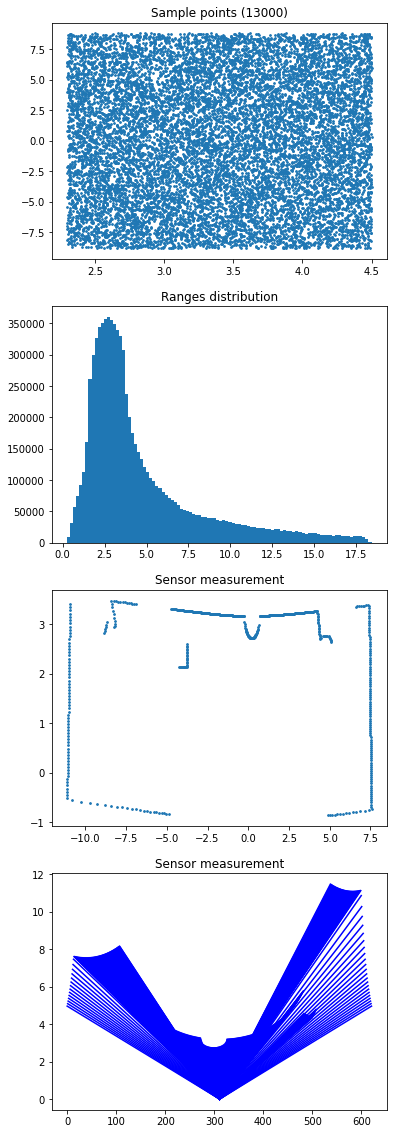

In [5]:
fig, axs = plt.subplots(4)
fig.set_figheight(20)

axs[0].set_title('Sample points ({length})'.format(length=len(pos)))
axs[0].scatter(pos[:, 0], pos[:, 1], s=3);

all_ranges = np.concatenate(ranges).ravel()
axs[1].set_title('Ranges distribution')
axs[1].hist(all_ranges, bins=100)

ranges_plot = prettify_ranges(ranges[0])
axs[2].set_title('Sensor measurement')
axs[2].scatter(ranges_plot[:, 0], ranges_plot[:, 1], s=3);

axs[3].set_title('Sensor measurement')
for i in range(len(ranges[0])):
    axs[3].plot([len(ranges[0])/2, i], [0, ranges[0][i]], '-b')

### Data normalization

In [6]:
ranges_max = ranges.max()
ranges_min = ranges.min()
positions_max = [pos[:, 0].max(), pos[:, 1].max()]
positions_min = [pos[:, 0].min(), pos[:, 1].min()]

def normalize_ranges(ranges_matrix):
    ranges_matrix = (ranges_matrix - ranges_min) / (ranges_max - ranges_min)
    return ranges_matrix
    
def normalize_pos(positions):
    positions[:, 0] = (positions[:, 0] - positions_min[0]) / (positions_max[0] - positions_min[0])
    positions[:, 1] = (positions[:, 1] - positions_min[1]) / (positions_max[1] - positions_min[1])
    return positions

def unormalize_ranges(ranges):
    return ranges * (ranges_max - ranges_min) + ranges_min;

def unnormalize_pos(positions):
    positions[:, 0] = positions[:, 0] * (positions_max[0] - positions_min[0]) + positions_min[0]
    positions[:, 1] = positions[:, 1] * (positions_max[1] - positions_min[1]) + positions_min[1]
    return positions

Train data points: 10000
Test data points: 3000
Length of ranges per data point: 622


(array([6.48700e+03, 2.26490e+04, 4.26520e+04, 5.70360e+04, 6.89870e+04,
        8.56580e+04, 1.22943e+05, 1.97716e+05, 2.26923e+05, 2.50756e+05,
        2.65094e+05, 2.69327e+05, 2.76742e+05, 2.77593e+05, 2.75314e+05,
        2.70793e+05, 2.61858e+05, 2.54014e+05, 2.36207e+05, 1.82953e+05,
        1.54937e+05, 1.35363e+05, 1.21638e+05, 1.12284e+05, 1.02236e+05,
        9.27470e+04, 8.65520e+04, 7.97910e+04, 7.72170e+04, 6.93910e+04,
        6.63860e+04, 6.14930e+04, 5.77660e+04, 5.51380e+04, 5.17220e+04,
        4.94440e+04, 4.53040e+04, 4.12580e+04, 3.98810e+04, 3.84180e+04,
        3.75490e+04, 3.51290e+04, 3.37080e+04, 3.32220e+04, 3.12110e+04,
        3.07270e+04, 3.03610e+04, 3.09570e+04, 2.99040e+04, 2.77070e+04,
        2.62970e+04, 2.70810e+04, 2.65860e+04, 2.50180e+04, 2.39220e+04,
        2.24850e+04, 2.21870e+04, 2.18220e+04, 2.07810e+04, 2.02810e+04,
        1.96460e+04, 1.89350e+04, 1.72430e+04, 1.72540e+04, 1.78510e+04,
        1.70070e+04, 1.70080e+04, 1.59290e+04, 1.61

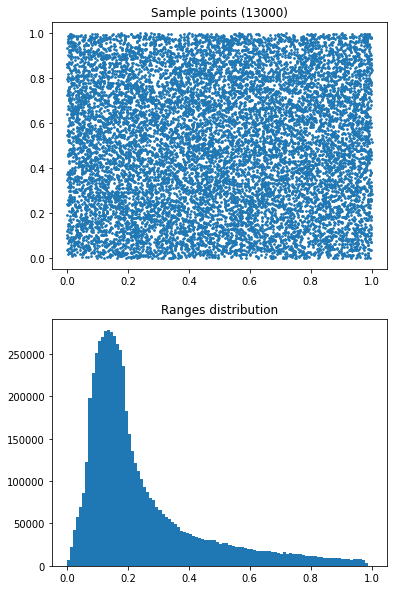

In [7]:
# Splitting dataset into test and train
dataset_size = len(pos)
train_data_percentage = 0.7693
train_upto_idx = int(dataset_size * train_data_percentage)

train_pos = pos[0 : train_upto_idx]
train_ranges = ranges[0 : train_upto_idx]
test_pos = pos[train_upto_idx : dataset_size]
test_ranges = ranges[train_upto_idx : dataset_size]


print('Train data points: {length}'.format(length=len(train_pos)))
print('Test data points: {length}'.format(length=len(test_pos)))
print('Length of ranges per data point: {length}'.format(length=len(ranges[0])))


# Normalizing data
train_pos = normalize_pos(train_pos)
train_ranges = normalize_ranges(train_ranges)
test_pos = normalize_pos(test_pos)
test_ranges = normalize_ranges(test_ranges)

# Visualizing normalized data
fig, axs = plt.subplots(2)
fig.set_figheight(10)

axs[0].set_title('Sample points ({length})'.format(length=len(pos)))
axs[0].scatter(pos[:, 0], pos[:, 1], s=3);

axs[1].set_title('Ranges distribution')
axs[1].hist(np.concatenate(train_ranges).ravel(), bins=100)

### Transposed Convolutional Neural Network

In [8]:
class ConvTransposeNet(nn.Module):
    def __init__(self):
        super(ConvTransposeNet, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(2, 99),
            nn.ReLU(),
            nn.Linear(99, 198),
            nn.ReLU(),
            
            nn.ConvTranspose1d(in_channels=1, out_channels = 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.ReLU(),
            nn.Conv1d(in_channels=1, out_channels = 1, kernel_size=1, stride=1, padding=0, bias=False),
            nn.ReLU(),
            nn.ConvTranspose1d(in_channels=1, out_channels = 1, kernel_size=22, stride=3, padding=0, bias=False),
            nn.ReLU(),
            nn.Conv1d(in_channels=1, out_channels = 1, kernel_size=1, stride=1, padding=0, bias=False),
            nn.ReLU(),
        )
        
        
    def forward(self, x):     
        out = self.layers(x)
        
        return out

In [9]:
torch.set_default_tensor_type('torch.DoubleTensor')

# Hyperparameters
num_epochs = 20
batch_size = 500
learning_rate = 0.002

train_tensor_dataset = TensorDataset(torch.from_numpy(train_pos).double(), torch.from_numpy(train_ranges).double())
train_loader = DataLoader(train_tensor_dataset, batch_size=batch_size, shuffle=True)

test_tensor_dataset = TensorDataset(torch.from_numpy(test_pos).double(), torch.from_numpy(test_ranges).double())
test_loader = DataLoader(test_tensor_dataset, batch_size=batch_size, shuffle=False)

test_batch_pos, test_batch_ranges = next(iter(test_loader))
test_batch_pos.unsqueeze_(1)
test_batch_ranges.unsqueeze_(1)

tensor([[[0.4822, 0.4953, 0.5090,  ..., 0.2823, 0.2826, 0.2830]],

        [[0.3744, 0.3846, 0.3954,  ..., 0.3954, 0.3846, 0.3744]],

        [[0.5297, 0.5290, 0.5283,  ..., 0.4912, 0.4919, 0.4926]],

        ...,

        [[0.2322, 0.2387, 0.2455,  ..., 0.2455, 0.2387, 0.2322]],

        [[0.2762, 0.2839, 0.2919,  ..., 0.2448, 0.2451, 0.2455]],

        [[0.6403, 0.6575, 0.6757,  ..., 0.3094, 0.3098, 0.3102]]])

### Model training

Final error: 0.04179534776324268


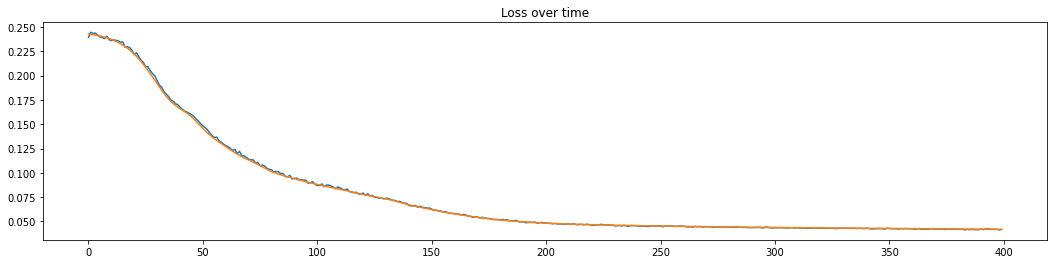

In [10]:
model = ConvTransposeNet()

# Loss and optimizer
# criterion = nn.MSELoss()
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
loss_list = []
test_loss_list = []
for epoch in range(num_epochs):
    for i, (pos, ranges) in enumerate(train_loader):        
        pos.unsqueeze_(1) # adds one extra dimension to make it (batch_size, 1, 1) for the ConvTranspose1d
        ranges.unsqueeze_(1)
        
        # Forward pass
        outputs = model(pos)
        
        # Loss computation
        loss = criterion(outputs, ranges)
        loss_list.append(loss.item())        
        
        # Backprop and perform Adam optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        
        # Test loss computation        
        test_outputs = model(test_batch_pos)
        test_loss = criterion(test_outputs, test_batch_ranges)
        test_loss_list.append(test_loss.item())


fig2, axs2 = plt.subplots()
fig2.set_figwidth(18)
axs2.set_title('Loss over time')
axs2.plot(np.arange(len(loss_list)), loss_list);
axs2.plot(np.arange(len(test_loss_list)), test_loss_list);

print('Final error: {x}'.format(x=loss_list[-1]))

### Model performance visualization

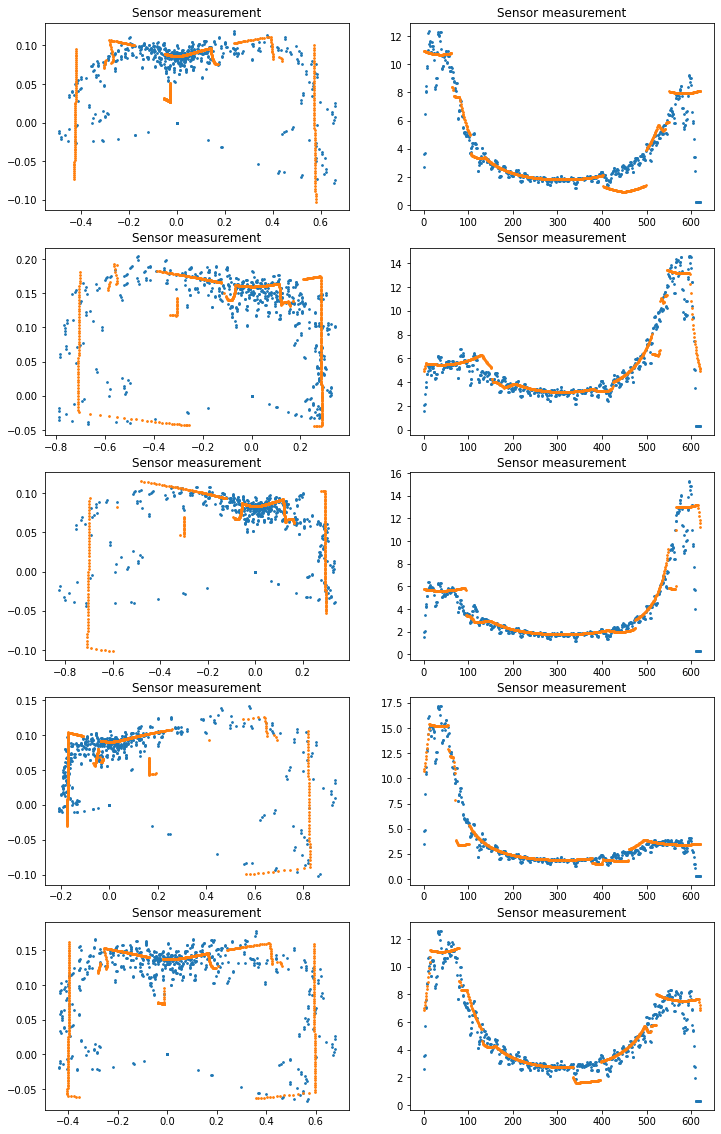

In [12]:
criterion = nn.L1Loss()
test_outputs = model(test_batch_pos)
test_loss = criterion(test_outputs, test_batch_ranges)

nr_plots = 5
fig3, axs3 = plt.subplots(nr_plots, 2)
fig3.set_figheight(nr_plots * 4)
fig3.set_figwidth(12)

for i in range(nr_plots):
    sample_idx = random.randint(0, len(test_outputs))
    single_output = test_outputs[sample_idx][0].detach().numpy()
    single_true_output = test_batch_ranges[sample_idx][0].detach().numpy()
    
    
    pred_ranges_prettified = prettify_ranges(single_output)
    true_ranges_prettified = prettify_ranges(single_true_output)
    axs3[i][0].set_title('Sensor measurement')
    axs3[i][0].scatter(pred_ranges_prettified[:, 0], pred_ranges_prettified[:, 1], s=3);
    axs3[i][0].scatter(true_ranges_prettified[:, 0], true_ranges_prettified[:, 1], s=3);
    
    axs3[i][1].set_title('Sensor measurement')
    axs3[i][1].scatter(np.arange(len(single_output)), unormalize_ranges(single_output), s=3);
    axs3[i][1].scatter(np.arange(len(single_true_output)), unormalize_ranges(single_true_output), s=3);
    

### Save model

In [ ]:
torch.save(model.state_dict(), "model_corridor")

### Load model

In [ ]:
model = ConvTransposeNet()
model.load_state_dict(torch.load("model_corridor"))
model.eval()

# Predictive coding model

In [13]:
def fep(belief_pos, real_ranges):
    input = Variable(belief_pos, requires_grad=True)

    # Generative model prediction (from internal state to sensory space)
    pred_ranges = model(input)

    # Prediction error (Free Energy)
    pred_error = real_ranges - pred_ranges   # torch.Size([1, 1, 622])        
    
    # Precision vector
    sigma = torch.tensor([1] * 622)   # torch.Size([622]) 

    # 
    dF_dg = (1/sigma) * pred_error  # torch.Size([1, 1, 622])

    # Sets gradient to zero
    input.grad=torch.zeros(input.size())
    
    # Backpagates the error
    pred_ranges.backward(torch.ones(pred_ranges.shape)*dF_dg,retain_graph=True)

    # Returns gradient
    return input.grad


def run(belief_pos, real_ranges, iterations):
    belief_hist = np.array([belief_pos.detach().numpy()[0][0]])
    
    for i in range(0, iterations):
        belief_pos_dot = fep(belief_pos, real_ranges)
        belief_pos = torch.add(belief_pos, belief_pos_dot, alpha=0.005) # alpha = learning rate
        belief_hist = np.append(belief_hist, [belief_pos.detach().numpy()[0][0]], axis=0)
    
    return belief_hist

Real pos: tensor([0.4727, 0.4263])
Initial belief of x: [0. 0.]
Final belief of x: [0.44861091 0.43115275]


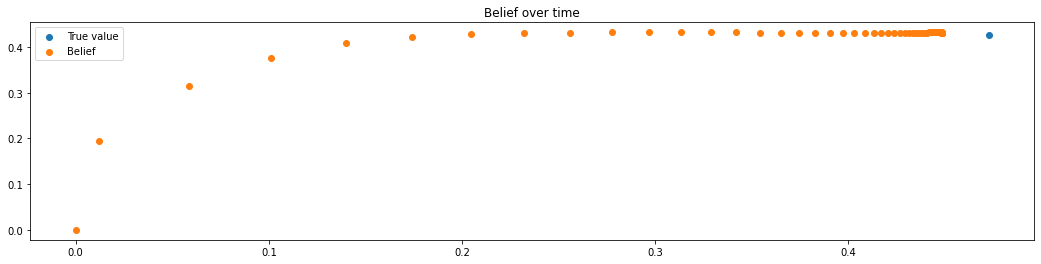

In [14]:
sample_idx = 120   # random sample from the test set
real_pos = test_batch_pos[sample_idx]    # real position
real_ranges = test_batch_ranges[sample_idx]    # real measurement
belief_pos = torch.tensor([[[0.0, 0.0]]])      # initial belief
iterations = 100

belief_hist = run(belief_pos, real_ranges, iterations)

print('Real pos: {x}'.format(x=real_pos[0]))
print('Initial belief of x: {x}'.format(x=belief_hist[0]))
print('Final belief of x: {x}'.format(x=belief_hist[-1]))

fig4, axs4 = plt.subplots()
fig4.set_figwidth(18)
axs4.set_title('Belief over time')
axs4.scatter(real_pos[0][0], real_pos[0][1], label='True value');
axs4.scatter(belief_hist[:, 0], belief_hist[:, 1], label='Belief');
axs4.legend();

(-9.0, 9.0)

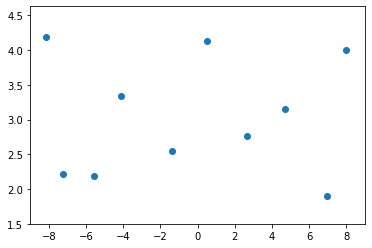

In [15]:
def load_comparative():
    with open("two_axis_statistics_inferred_poses.json", "r") as read_file:
        data = json.load(read_file)
        
        inferred = np.array(list(map(lambda x: [
            x['amcl']['x'],
            x['amcl']['y']
        ], data)))
        
        true = np.array(list(map(lambda x: [
            x['true']['x'],
            x['true']['y']
        ], data)))
        
        ranges = np.array(list(map(lambda x: x['laser'], data)))        
        ranges[ranges == np.inf] = 15  # replaces infinity values with 20
        
        # Ranges in all samples are prefixed and sufixed with 22 constant values (close to 0)
        trim_size = 22
        for i in range(0, trim_size):
            ranges = np.delete(ranges, 0, axis=1)
        for i in range(0, trim_size):
            ranges = np.delete(ranges, len(ranges[0]) - 1, axis=1)
        
    return inferred, true, ranges

stat_inferred, stat_true, stat_ranges = load_comparative()

plt.scatter(stat_true[:,1], stat_true[:,0], label='True');
plt.ylim([1.5, 4.63])
plt.xlim([-9, 9])

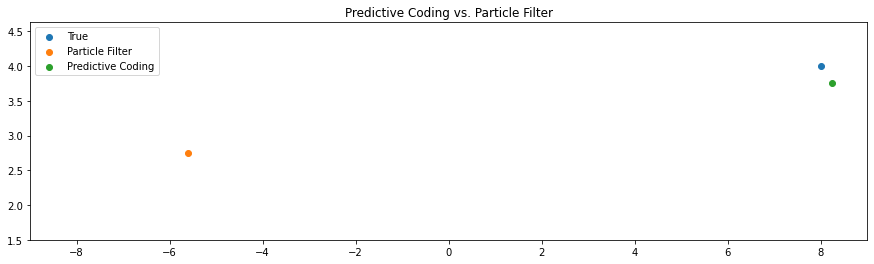

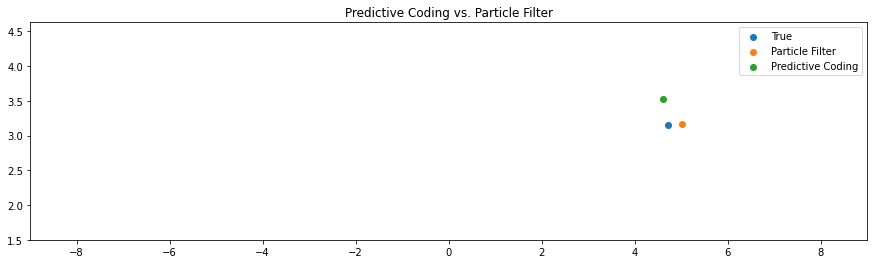

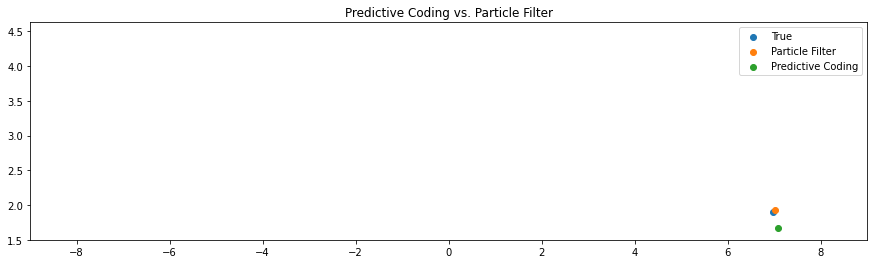

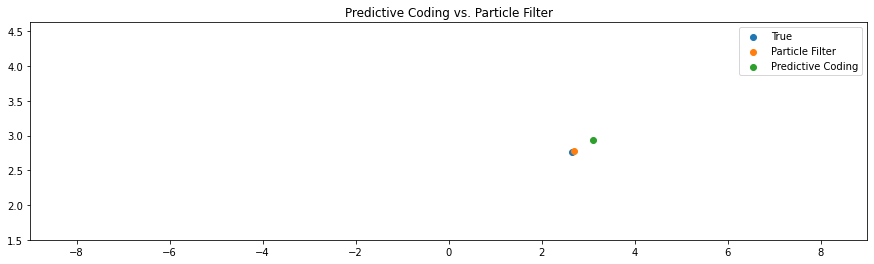

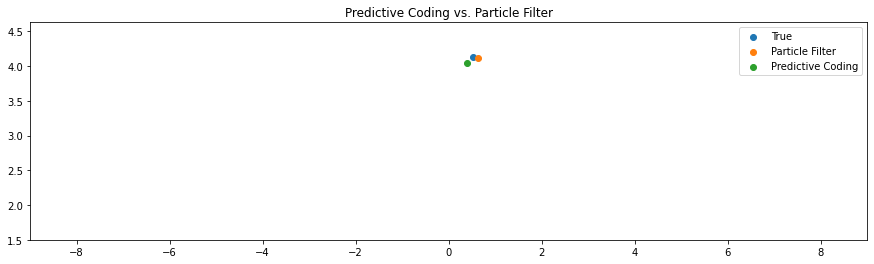

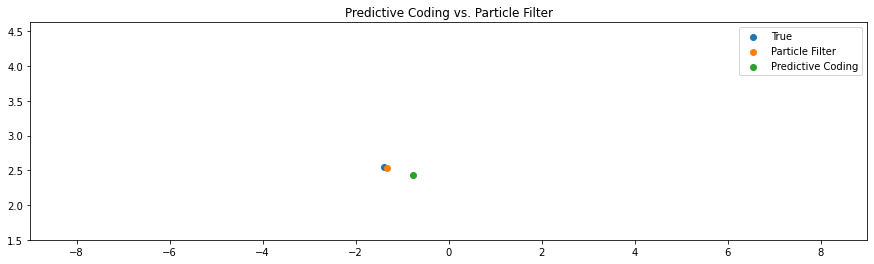

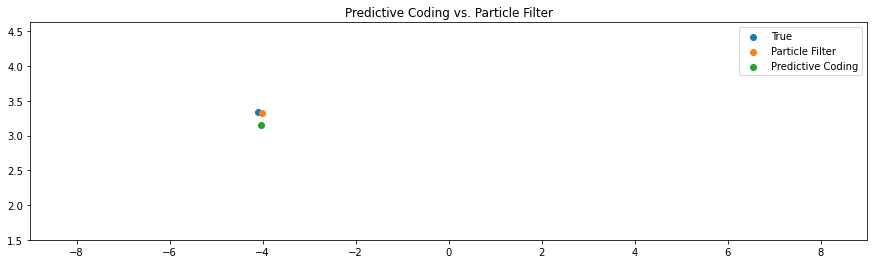

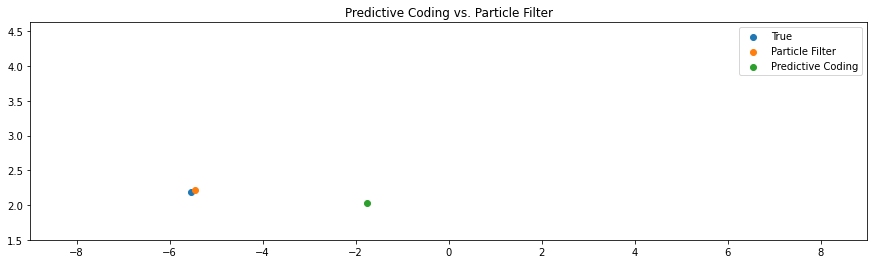

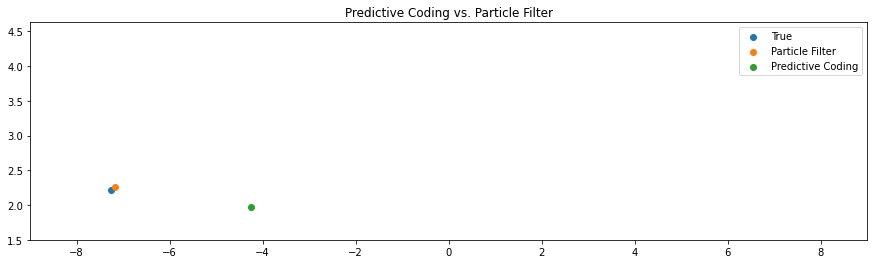

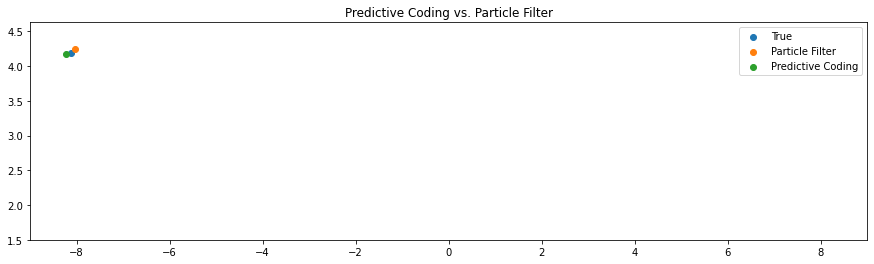

In [19]:
stat_ranges_normalized = normalize_ranges(stat_ranges)
stat_model = []
for i in range(len(stat_ranges_normalized)):
    model_pred = run(torch.tensor([[[0.0, 0.0]]]), torch.tensor([stat_ranges_normalized[i]]), iterations)[-1]
    stat_model.append(model_pred)

stat_model = unnormalize_pos(np.array(stat_model))

for i in range(len(stat_true)):
    fig5, axs5 = plt.subplots()
    fig5.set_figwidth(15)
    axs5.set_title('Predictive Coding vs. Particle Filter')
    axs5.scatter(stat_true[i][1], stat_true[i][0], label='True');
    axs5.scatter(stat_inferred[i][1], stat_inferred[i][0], label='Particle Filter');
    axs5.scatter(stat_model[i][1], stat_model[i][0], label='Predictive Coding');
    axs5.legend()
    plt.ylim([1.5, 4.63])
    plt.xlim([-9, 9])

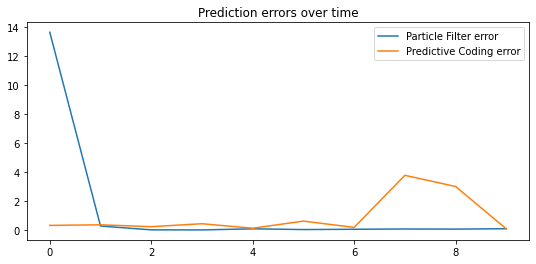

In [18]:
diffs_particle = abs(stat_inferred - stat_true)
diffs_model = abs(stat_model - stat_true)

errors_particle = np.array(list(map(lambda x: math.sqrt(math.pow(x[0], 2) + math.pow(x[1], 2)), diffs_particle)))
errors_model = np.array(list(map(lambda x: math.sqrt(math.pow(x[0], 2) + math.pow(x[1], 2)), diffs_model)))

fig6, axs6 = plt.subplots()
fig6.set_figwidth(9)
axs6.set_title('Prediction errors over time')
axs6.plot(np.arange(len(errors_particle)), errors_particle, label='Particle Filter error');
axs6.plot(np.arange(len(errors_model)), errors_model, label='Predictive Coding error');
axs6.legend()